Epoch 10/10: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s, loss=2.29]


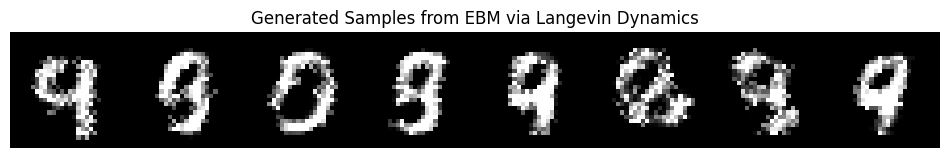

In [2]:
# Energy-Based Model (EBM) for MNIST with Langevin Dynamics Sampling

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data
dataset = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# EBM Model: maps input to scalar energy
class EBM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

# Langevin dynamics sampling
def sample_langevin(model, shape, steps=60, step_size=0.1, noise_scale=0.005):
    x = torch.randn(shape, device=device, requires_grad=True)
    for _ in range(steps):
        energy = model(x)
        grad = torch.autograd.grad(energy.sum(), x, create_graph=False)[0]
        noise = torch.randn_like(x) * noise_scale
        x.data -= 0.5 * step_size * grad + noise
        x.data.clamp_(0, 1)
    return x.detach()

# Initialize model and optimizer
model = EBM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/10")
    for real, _ in pbar:
        real = real.to(device)

        # Sample from model
        fake = sample_langevin(model, real.shape)

        # Compute energies
        energy_real = model(real)
        energy_fake = model(fake)

        # Loss: maximize energy of fake, minimize energy of real
        loss = (energy_real - energy_fake).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

# Generate and show samples
samples = sample_langevin(model, (8, 1, 28, 28), steps=100)

def show_images(images, title=""):
    grid = torch.cat([img.squeeze(0) for img in images], dim=1).cpu().numpy()
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_images(samples, title="Generated Samples from EBM via Langevin Dynamics")
